In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
from pathlib import Path
from collections import Counter

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import dill
import pandas as pd
import polars as pl
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import GroupKFold

import lightgbm as lgb

import pytorch_lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from tasks.data.dataset.mappers import EntityEncoder
from tasks.jobs import Splitter

In [51]:
from otto_utils import *
from otto_features import *
from otto_candidates_covisit import *
from otto_lgbm_utils import *
from otto_implicit import *

In [ ]:
%env PYTHONHASHSEED=1
from otto_word2vec import *

w2vec = Word2Vec.load("__valid__word2vec_window=10_negative=20.w2v")

# Load data

## valid

In [4]:
# load
val_df_train = pl.read_parquet(VALIDATION_PATH / "train.parquet", use_pyarrow=True)
val_df_valid_input = pl.read_parquet(VALIDATION_PATH / "valid.parquet", use_pyarrow=True)
val_df_valid_targets = pl.read_parquet(VALIDATION_PATH / "test_labels.parquet", use_pyarrow=True)

# Features

## user features

In [5]:
df = val_df_valid_input.unique().sort(["session", "ts"])

In [6]:
df_user_action_stats_features = user_action_stats_features(df)

In [ ]:
# df_user_time_distr_features = user_time_distr_features(df)

In [11]:
# df_user_action_stats_features.write_parquet("__features__valid__user_action_stats_v1.parquet")
# df_user_time_distr_features.write_parquet("__features__valid__user_time_distr_v1.parquet")

## user item features

In [7]:
df = val_df_valid_input.unique().sort(["session", "ts"])

In [8]:
df_user_item_history_features = user_item_history_features(df)

In [11]:
df_user_last_type_actions = (
    df
    .groupby(["session", "type"])
    .agg([
        pl.last("aid")
    ])
    .pivot(values="aid", index="session", columns="type")
    .rename({
        "0": "last_click_aid",
        "1": "last_cart_aid",
        "2": "last_order_aid",
    })
    .sort("session")
)

In [12]:
df_user_item_history_features.write_parquet("__features__valid__user_item_history_v1.parquet")
df_user_last_type_actions.write_parquet("__features__valid__user_last_type_actions_v1.parquet")

## item features

In [13]:
df = pl.concat([val_df_train, val_df_valid_input]).unique().sort(["session", "ts"])

In [14]:
df_item_action_stats_features = item_action_stats_features(df)

In [ ]:
# df_item_time_distr_features = item_time_distr_features(df)

In [15]:
df_item_n_sess_multiple_action = item_n_sessions_with_repeated_actions(df)

In [16]:
df_item_w2v_embeddings = get_w2v_embeddings(w2vec)

env: PYTHONHASHSEED=1


In [16]:
df_item_action_stats_features.write_parquet("__features__valid__item_action_stats_v1.parquet")
df_item_time_distr_features.write_parquet("__features__valid__item_time_distr_v1.parquet")
df_item_n_sess_multiple_action.write_parquet("__features__valid__item_n_sess_multiple_action_v1.parquet")
df_item_w2v_embeddings.write_parquet("__features__valid__item_w2v_embeddings_window=10_negative=20.parquet")

# Candidates

In [26]:
ACT_TYPE = "orders"

## prepare target and candidates set with this target in holdout (other users for action does not change metric)

In [34]:
df_act_target = (
    val_df_valid_targets
    .filter(pl.col("type") == ACT_TYPE)
    .join(val_df_valid_input.select(["session"]).unique(), on="session", how="inner")
    .drop("type")
    .explode("ground_truth")
    .with_column(pl.lit(1).alias("target"))
    .rename({"ground_truth": "aid"})
)

In [35]:
df = val_df_valid_input.unique().sort(["session", "ts"])

In [36]:
test_df = (
    df
    .join(df_act_target.select(["session"]).unique(), on="session", how="inner")
    .unique().sort(["session", "ts"])
)
test_sessions_dict = test_df.groupby('session').agg([pl.list("aid"), pl.list("type")])
test_sessions_dict = dict(zip(
    test_sessions_dict["session"].to_list(),
    tuple(zip(test_sessions_dict["aid"].to_list(), test_sessions_dict["type"].to_list()))
))

## covisitation top200

In [37]:
# Use top X for clicks, carts and orders
clicks_th = 15
carts_th  = 20
orders_th = 20

def get_top(df, th):
    return (
        df
        .with_column(pl.lit(1).alias("ones"))
        .with_column(pl.col("ones").cumsum().over("aid").alias("rank"))
        .filter(pl.col("rank") <= th)
    )

TOPK_RECOMMEND = 20
TOPK_RERANK = 40

In [38]:
carts_orders = pl.read_parquet("__valid__covisit_carts_orders_all_v3.parquet")
buys2buys = pl.read_parquet("__valid__covisit_buys2buys_all_v4.parquet")
clicks = pl.read_parquet("__valid__covisit_clicks_all_v3.parquet")

In [39]:
carts_orders_top = get_top(carts_orders, carts_th)
buys2buys_top = get_top(buys2buys, orders_th)
clicks_top = get_top(clicks, clicks_th)

In [40]:
top_clicks = df.filter(pl.col("type") == 0)["aid"].value_counts(sort=True)[:TOPK_RECOMMEND]["aid"].to_list()
top_carts = df.filter(pl.col("type") == 1)["aid"].value_counts(sort=True)[:TOPK_RECOMMEND]["aid"].to_list()
top_orders = df.filter(pl.col("type") == 2)["aid"].value_counts(sort=True)[:TOPK_RECOMMEND]["aid"].to_list()

In [41]:
covisit_rec = CovisitationRecommender(
    df_top_k_buys=carts_orders_top,
    df_top_k_buy2buy=buys2buys_top,
    df_top_k_clicks=clicks_top,
    top_carts=top_carts,
    top_orders=top_orders,
    top_clicks=top_clicks,
)

In [42]:
candidates_dict = {
    "session": [],
    "type": [],
    "candidates": [],
    "rank": [],
}

types = ["clicks", "carts", "orders"]
# types = ["orders"]
topk = TOPK_RERANK * 5
# topk = TOPK_RERANK

for session_id, (session_aid_list, session_type_list) in tqdm(test_sessions_dict.items()):
    rec_items_clicks = covisit_rec.recommend_clicks(session_aid_list, session_type_list, topk)
    rec_items_carts = covisit_rec.recommend_carts(session_aid_list, session_type_list, topk)
    rec_items_buys = covisit_rec.recommend_buys(session_aid_list, session_type_list, topk)

    candidates = [rec_items_clicks, rec_items_carts, rec_items_buys]
#     candidates = [rec_items_buys]
    ranks = [
        np.arange(1, len(rec_items) + 1).tolist()
        for rec_items in candidates
    ]
    
    candidates_dict["session"].extend([session_id] * len(types))
    candidates_dict["type"].extend(types)
    candidates_dict["candidates"].extend(candidates)
    candidates_dict["rank"].extend(ranks)

df_candidates_covisit = pl.DataFrame(candidates_dict)

100%|██████████| 134666/134666 [00:19<00:00, 7061.00it/s]


### RECALL TOP200

In [110]:
t_submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = TOPK_RERANK * 5

for session_id, (session_aid_list, session_type_list) in tqdm(test_sessions_dict.items()):
    rec_items_clicks = covisit_rec.recommend_clicks(session_aid_list, session_type_list, topk)
    rec_items_carts = covisit_rec.recommend_carts(session_aid_list, session_type_list, topk)
    rec_items_buys = covisit_rec.recommend_buys(session_aid_list, session_type_list, topk)
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels_list = [
        " ".join(str(aid) for aid in rec_items)
        for rec_items in [rec_items_clicks, rec_items_carts, rec_items_buys]
    ]
    
    t_submission_dict["session_type"].extend(session_types)
    t_submission_dict["labels"].extend(labels_list)

df_t_candidates = pl.DataFrame(t_submission_dict)

  0%|          | 0/1303355 [00:00<?, ?it/s]

In [111]:
# before reranking
# df_submission_valid = pl.DataFrame(submission_dict)
calc_valid_score(df_t_candidates, topk=topk)

validation score: 0.6140460248180033
recall per type: type
carts    0.4763
clicks   0.5565
orders   0.6925
dtype: float64


,session_type,labels,session,type,ground_truth,hits,gt_count
0,11107743_clicks,"[1243310, 731062, 224347, 1838173, 666582, 631...",11107743,clicks,[224347],1,1
1,11107743_carts,"[1243310, 731062, 984459, 224347, 1838173, 666...",11107743,carts,[],0,0
2,11107743_orders,"[1243310, 731062, 984459, 224347, 666582, 1843...",11107743,orders,[],0,0
3,11107744_clicks,"[1556644, 1637748, 220086, 830498, 263196, 151...",11107744,clicks,[1075085],0,1
4,11107744_carts,"[1556644, 1637748, 220086, 830498, 959553, 813...",11107744,carts,"[165989, 178869, 628545, 1075085]",0,4
...,...,...,...,...,...,...,...
3910060,12899775_carts,"[1743151, 1760714, 1255910, 1163166, 1498443, ...",12899775,carts,[],0,0
3910061,12899775_orders,"[1743151, 1760714, 1255910, 1498443, 1163166, ...",12899775,orders,[],0,0
3910062,12899777_clicks,"[384045, 1308634, 1688215, 703474, 395762, 148...",12899777,clicks,[384045],1,1
3910063,12899777_carts,"[384045, 1308634, 1688215, 703474, 395762, 148...",12899777,carts,[],0,0


## implicit i2i k=100 top100

In [ ]:
from implicit.nearest_neighbours import CosineRecommender

### old weights

In [47]:
df = pl.concat([val_df_train, val_df_valid_input]).unique().sort(["session", "ts"])
df = implicit_old_weight_interactions(df)

In [49]:
train_data = make_sparse_matrix(df)
i2i = CosineRecommender(K=100)
i2i.fit(train_data)

  0%|          | 0/1855603 [00:00<?, ?it/s]

In [50]:
df_candidates_i2i_old = implicit_batch_candidates_for_all_types(
    model=i2i, model_name="i2i_old",
    train_data=train_data, test_users=list(test_sessions_dict.keys()),
    topk=100,
)

100%|██████████| 135/135 [00:12<00:00, 10.79it/s]


#### RECALL TOP100

In [22]:
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = 100

test_users =  val_df_valid_input["session"].unique().to_list()
b_sz = 1000
# df_candidates_orders_target = (
#     df_candidates.join(
#         df_stage_2_dataset_train.select(["session"]).unique(),
#         on="session",
#     )
# )
recs = []
for test_session_start in tqdm(range(0, len(test_users), b_sz)):
    test_sessions = test_users[test_session_start : test_session_start + b_sz]
    rec_items, scores = i2i.recommend(
        test_sessions, user_items=train_data[test_sessions], N=topk,
        filter_already_liked_items=False, recalculate_user=False
    )
    session_types = [
        [f"{session_id}_{t}" for t in types]
        for session_id in test_sessions
    ]
    labels_list = [
        [" ".join(str(aid) for aid in recs.tolist())] * 3
        for recs in rec_items
    ]
    
    submission_dict["session_type"].extend(itertools.chain(*session_types))
    submission_dict["labels"].extend(itertools.chain(*labels_list))
    
df_submission_i2i = pl.DataFrame(submission_dict)

100%|██████████| 1304/1304 [01:55<00:00, 11.31it/s]


In [23]:
# k=100, topk=100
calc_valid_score(df_submission_i2i, topk=topk)

validation score: 0.5729102013897956
recall per type: type
carts    0.4176
clicks   0.5337
orders   0.6571
dtype: float64


,session_type,labels,session,type,ground_truth,hits,gt_count
0,11107743_clicks,"[42679, 1180098, 100644, 595198, 1846345, 8192...",11107743,clicks,[224347],1,1
1,11107743_carts,"[42679, 1180098, 100644, 595198, 1846345, 8192...",11107743,carts,[],0,0
2,11107743_orders,"[42679, 1180098, 100644, 595198, 1846345, 8192...",11107743,orders,[],0,0
3,11107744_clicks,"[197860, 665389, 292303, 858592, 1735650, 2466...",11107744,clicks,[1075085],0,1
4,11107744_carts,"[197860, 665389, 292303, 858592, 1735650, 2466...",11107744,carts,"[165989, 178869, 628545, 1075085]",0,4
...,...,...,...,...,...,...,...
3910060,12899775_carts,"[1452543, 274432, 1798464, 1285924, 266745, 16...",12899775,carts,[],0,0
3910061,12899775_orders,"[1452543, 274432, 1798464, 1285924, 266745, 16...",12899775,orders,[],0,0
3910062,12899777_clicks,"[928342, 70933, 1642470, 551472, 1183678, 9875...",12899777,clicks,[384045],1,1
3910063,12899777_carts,"[928342, 70933, 1642470, 551472, 1183678, 9875...",12899777,carts,[],0,0


### new weights

In [52]:
df = pl.concat([val_df_train, val_df_valid_input]).unique().sort(["session", "ts"])
df = implicit_new_weight_interactions(df)

In [54]:
train_data = make_sparse_matrix(df)
i2i = CosineRecommender(K=100)
i2i.fit(train_data)

  0%|          | 0/1855603 [00:00<?, ?it/s]

In [55]:
df_candidates_i2i_new = implicit_batch_candidates_for_all_types(
    model=i2i, model_name="i2i_new",
    train_data=train_data, test_users=list(test_sessions_dict.keys()),
    topk=100,
)

100%|██████████| 135/135 [00:12<00:00, 10.93it/s]


#### RECALL TOP100

In [164]:
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = 100

test_users = df_stage_2_dataset_train["session"].unique().to_list()
b_sz = 1000
# df_candidates_orders_target = (
#     df_candidates.join(
#         df_stage_2_dataset_train.select(["session"]).unique(),
#         on="session",
#     )
# )
recs = []
for test_session_start in tqdm(range(0, len(test_users), b_sz)):
    test_sessions = test_users[test_session_start : test_session_start + b_sz]
    rec_items, scores = i2i.recommend(
        test_sessions, user_items=train_data[test_sessions], N=topk,
        filter_already_liked_items=False, recalculate_user=False
    )
    session_types = [
        [f"{session_id}_{t}" for t in types]
        for session_id in test_sessions
    ]
    labels_list = [
        [" ".join(str(aid) for aid in recs.tolist())] * 3
        for recs in rec_items
    ]
    
    submission_dict["session_type"].extend(itertools.chain(*session_types))
    submission_dict["labels"].extend(itertools.chain(*labels_list))
    
df_submission_i2i = pl.DataFrame(submission_dict)

100%|██████████| 1304/1304 [01:50<00:00, 11.83it/s]


In [165]:
# k=100, topk=100
calc_valid_score(df_submission_i2i, topk=topk)

validation score: 0.5635470844553903
recall per type: type
carts    0.4111
clicks   0.5247
orders   0.6462
dtype: float64


,session_type,labels,session,type,ground_truth,hits,gt_count
0,11107743_clicks,"[257092, 356891, 770793, 619520, 1453674, 9645...",11107743,clicks,[224347],1,1
1,11107743_carts,"[257092, 356891, 770793, 619520, 1453674, 9645...",11107743,carts,[],0,0
2,11107743_orders,"[257092, 356891, 770793, 619520, 1453674, 9645...",11107743,orders,[],0,0
3,11107744_clicks,"[1628192, 1510820, 569540, 1309038, 1682136, 3...",11107744,clicks,[1075085],0,1
4,11107744_carts,"[1628192, 1510820, 569540, 1309038, 1682136, 3...",11107744,carts,"[165989, 178869, 628545, 1075085]",0,4
...,...,...,...,...,...,...,...
3910060,12899775_carts,"[1031359, 817417, 1175016, 711226, 368724, 165...",12899775,carts,[],0,0
3910061,12899775_orders,"[1031359, 817417, 1175016, 711226, 368724, 165...",12899775,orders,[],0,0
3910062,12899777_clicks,"[1133242, 288507, 754796, 1746943, 250382, 960...",12899777,clicks,[384045],1,1
3910063,12899777_carts,"[1133242, 288507, 754796, 1746943, 250382, 960...",12899777,carts,[],0,0


## before reranking submission result

In [83]:
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["clicks", "carts", "orders"]
topk = TOPK_RECOMMEND

for session_id, (session_aid_list, session_type_list) in tqdm(test_sessions_dict.items()):
    rec_items_clicks = covisit_rec.recommend_clicks(session_aid_list, session_type_list, topk)
    rec_items_carts = covisit_rec.recommend_carts(session_aid_list, session_type_list, topk)
    rec_items_buys = covisit_rec.recommend_buys(session_aid_list, session_type_list, topk)

    session_types = [f"{session_id}_{t}" for t in types]
    labels_list = [
        " ".join(str(aid) for aid in rec_items)
        for rec_items in [rec_items_clicks, rec_items_carts, rec_items_buys]
    ]
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

df_submission_valid = pl.DataFrame(submission_dict)

100%|██████████| 1303355/1303355 [01:50<00:00, 11818.07it/s]


In [86]:
# before reranking
valid_metrics_stats = calc_valid_score(df_submission_valid, topk=TOPK_RECOMMEND)

validation score: 0.5553397377087794
recall per type: type
carts    0.3932
clicks   0.5155
orders   0.6430
dtype: float64


# Reranker

In [59]:
df_candidates_for_orders_all = (
    df_candidates_covisit
    .join(
        df_act_target.select(["session"]).unique(),
        on="session", how="inner"
    )
    .filter(pl.col("type") == "orders")
    .drop("type")
    .explode(["candidates", "rank"])
    .rename({"candidates": "aid", "rank": "rank_orders"})
    .join(
        (
            df_candidates_covisit
            .join(
                df_act_target.select(["session"]).unique(),
                on="session", how="inner"
            )
            .filter(pl.col("type") == "carts")
            .drop("type")
            .explode(["candidates", "rank"])
            .rename({"candidates": "aid", "rank": "rank_carts"})
        ),
        on=["session", "aid"],
        how="outer"
    )
    .join(
        (
            df_candidates_covisit
            .join(
                df_act_target.select(["session"]).unique(),
                on="session", how="inner"
            )
            .filter(pl.col("type") == "clicks")
            .drop("type")
            .explode(["candidates", "rank"])
            .rename({"candidates": "aid", "rank": "rank_clicks"})
        ),
        on=["session", "aid"],
        how="outer"
    )
    .join(
        (
            df_candidates_i2i_new
            .join(
                df_act_target.select(["session"]).unique(),
                on="session", how="inner"
            )
            .explode(["aid", "i2i_new_score"])
        ),
        on=["session", "aid"],
        how="outer"
    )
    .join(
        (
            df_candidates_i2i_old
            .join(
                df_act_target.select(["session"]).unique(),
                on="session", how="inner"
            )
            .explode(["aid", "i2i_old_score"])
        ),
        on=["session", "aid"],
        how="outer"
    )
    .fill_null(999)
)

In [60]:
df_candidates_for_orders_all

session,aid,rank_orders,rank_carts,rank_clicks,i2i_new_score,i2i_old_score
i64,i64,i64,i64,i64,f64,f64
11107757,69701,1,1,1,1.0,10.0
11107757,441214,2,2,2,0.071773,10.254678
11107757,1522691,3,3,3,0.065949,0.755075
11107757,1777631,4,4,4,999.0,1.08279
11107757,416657,6,5,18,999.0,0.562457
11107757,1285692,7,6,20,999.0,0.4709
11107757,1355234,13,7,6,0.048101,999.0
11107757,721908,8,8,7,0.180393,1.798018
11107757,457354,11,9,8,999.0,999.0


In [98]:
# candidates i2i (old + new) + covisit all

df_stage_2_dataset_train = (
    df_candidates_for_orders_all
    .join(df_act_target, on=["session", "aid"], how="left")  # if using rank column as a feature
    .join(df_act_target.select(["session"]).unique(), on="session", how="inner")
    .sort("session")
    .unique(subset=["session", "aid"], keep="last").fill_null(0)
)

In [99]:
df_stage_2_dataset_train["target"].value_counts()

target,counts
i32,u32
0,33261018
1,205726


In [121]:
df_stage_2_dataset_train["target"].value_counts()

target,counts
i32,u32
0,28628452
1,204959


In [73]:
df_stage_2_dataset_train["target"].value_counts()

target,counts
i32,u32
0,18180710
1,202685


In [31]:
df_stage_2_dataset_train["target"].value_counts()

target,counts
i32,u32
0,24002459
1,202976


In [63]:
df_stage_2_dataset_train.head(1)

session,aid,rank_orders,rank_carts,rank_clicks,i2i_new_score,i2i_old_score,target
i64,i64,i64,i64,i64,f64,f64,i32
11107757,69701,1,1,1,1.0,10.0,1


#### only covisit

In [26]:
df_stage_2_dataset_train = (
    df_candidates
    .filter(pl.col("type") == "orders")
    .drop("type")
    .explode(["candidates", "rank"])
#     .drop("rank")
    .rename({"candidates": "aid"})
#     .join(carts_target, on=["session", "aid"], how="outer")
    .join(orders_target, on=["session", "aid"], how="left")  # if using rank column as a feature
    .join(orders_target.select(["session"]).unique(), on="session", how="inner")
    .sort("session")
    .unique(subset=["session", "aid"], keep="last").fill_null(0)
)

In [28]:
df_stage_2_dataset_train["target"].value_counts()

target,counts
i32,u32
0,13367038
1,200092


In [60]:
df_stage_2_dataset_train.filter(pl.col("rank") != 999)["target"].value_counts()

target,counts
i32,u32
0,13367038
1,200092


### join features

In [100]:
df_stage_2_dataset_train = (
    df_stage_2_dataset_train
    .join(df_user_last_type_actions, on="session", how="left")
)

In [102]:
for t in tqdm(["last_click_aid", "last_cart_aid", "last_order_aid"]):
    df_w2v_score = (
        df_stage_2_dataset_train.filter(
            (pl.col(t).is_not_null()) &
            (pl.col("aid") != -1)
        ).select(["session", "aid", t])
    )
    
    l_aids = df_w2v_score["aid"].to_numpy()
    r_aids = df_w2v_score[t].to_numpy()
    
    cosine_sim_score = w2v_cosine_sim(w2vec, l_aids, r_aids)
    df_w2v_score = df_w2v_score.with_column(pl.Series(cosine_sim_score).alias(f"w2v_cosine_sim_{t}"))
    
    df_stage_2_dataset_train = (
        df_stage_2_dataset_train.join(df_w2v_score, on=["session", "aid", t], how="left")
        .with_column(pl.col(f"w2v_cosine_sim_{t}").fill_null(pl.lit(-999)))
    )

100%|██████████| 3/3 [00:48<00:00, 16.13s/it]


In [103]:
df_stage_2_dataset_train = (
    df_stage_2_dataset_train
    .join(
        carts_orders.rename({"weight": "user_last_click_aid_carts_orders_weight"}),
        left_on=["aid", "last_click_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        buys2buys.rename({"weight": "user_last_click_aid_buy2buy_weight"}),
        left_on=["aid", "last_click_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        clicks.rename({"weight": "user_last_click_aid_click_weight"}),
        left_on=["aid", "last_click_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        carts_orders.rename({"weight": "user_last_cart_aid_carts_orders_weight"}),
        left_on=["aid", "last_cart_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        buys2buys.rename({"weight": "user_last_cart_aid_buy2buy_weight"}),
        left_on=["aid", "last_cart_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        clicks.rename({"weight": "user_last_cart_aid_click_weight"}),
        left_on=["aid", "last_cart_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        carts_orders.rename({"weight": "user_last_order_aid_carts_orders_weight"}),
        left_on=["aid", "last_order_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        buys2buys.rename({"weight": "user_last_order_aid_buy2buy_weight"}),
        left_on=["aid", "last_order_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .join(
        clicks.rename({"weight": "user_last_order_aid_click_weight"}),
        left_on=["aid", "last_order_aid"], right_on=["aid", "aid_right"], how="left"
    )
    .drop(["last_click_aid", "last_cart_aid", "last_order_aid"])
    .fill_null(0)
)

In [104]:
df_stage_2_dataset_train = (
    df_stage_2_dataset_train
    .join(df_user_action_stats_features, on="session", how="left")
#     .join(df_user_time_distr_features, on="session", how="left")
    .join(df_item_action_stats_features, on="aid", how="left")
#     .join(df_item_time_distr_features, on="aid", how="left") # лишний признак
    .join(df_item_n_sess_multiple_action, on="aid", how="left")
    .join(df_user_item_history_features, on=["session", "aid"], how="left")
    .sort("session")
    .fill_null(0)
)

In [105]:
df_stage_2_dataset_train.head()

session,aid,rank_orders,rank_carts,rank_clicks,i2i_new_score,i2i_old_score,target,w2v_cosine_sim_last_click_aid,w2v_cosine_sim_last_cart_aid,w2v_cosine_sim_last_order_aid,user_last_click_aid_carts_orders_weight,user_last_click_aid_buy2buy_weight,user_last_click_aid_click_weight,user_last_cart_aid_carts_orders_weight,user_last_cart_aid_buy2buy_weight,user_last_cart_aid_click_weight,user_last_order_aid_carts_orders_weight,user_last_order_aid_buy2buy_weight,user_last_order_aid_click_weight,user_lifetime_days,user_n_actions,user_n_uniq_items,user_buys_rate,user_uniq_clicks,user_uniq_carts,user_uniq_orders,cl_cnt,ca_cnt,or_cnt,user_ca_cl_ratio,user_or_cl_ratio,user_or_ca_ratio,item_lifetime_days,item_n_actions,item_n_uniq_users,item_buys_rate,item_uniq_clicks,item_uniq_carts,item_uniq_orders,cl_cnt_right,ca_cnt_right,or_cnt_right,item_ca_cl_ratio,item_or_cl_ratio,item_or_ca_ratio,item_n_sess_multi_clicks,item_n_sess_multi_carts,item_n_sess_multi_buys,user_item_log_recency_score,user_item_type_weighted_log_recency_score,user_item_is_in_history
i64,i64,i64,i64,i64,f64,f64,i32,f64,f64,f64,f64,i32,f64,f64,i32,f64,f64,i32,f64,f64,u32,u32,f64,u32,u32,u32,u32,u32,u32,f64,f64,f64,f64,u32,u32,f64,u32,u32,u32,u32,u32,u32,f64,f64,f64,u32,u32,u32,f64,f64,i32
11107757,69701,1,1,1,1.0,10.0,1,1.0,-999.0,-999.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,26.755954,422,1,0.042654,299,9,2,406,14,2,0.034483,0.004926,0.142857,63,1,0,1.0,1.0,1
11107757,441214,2,2,2,0.071773,10.254678,0,0.937693,-999.0,-999.0,8.5,0,39.636885,0.0,0,0.0,0.0,0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.937732,1509,1,0.051027,927,41,14,1446,49,14,0.033887,0.009682,0.285714,254,6,0,0.071773,0.071773,1
11107757,1522691,3,3,3,0.065949,0.755075,0,0.961893,-999.0,-999.0,19.5,1,83.20263,0.0,0,0.0,0.0,0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.956197,4184,1,0.090822,1965,287,0,3804,380,0,0.099895,0.0,0.0,739,63,0,0.0,0.0,0
11107757,1777631,4,4,4,999.0,1.08279,0,0.961586,-999.0,-999.0,23.5,0,61.517635,0.0,0,0.0,0.0,0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.942352,5716,1,0.098146,3018,252,114,5277,317,122,0.060072,0.023119,0.384858,998,42,8,0.0,0.0,0
11107757,416657,6,5,18,999.0,0.562457,0,0.947978,-999.0,-999.0,4.5,0,18.822306,0.0,0,0.0,0.0,0,0.0,0.000712,2,2,0.0,2,0,0,2,0,0,0.0,0.0,0.0,27.828345,2411,1,0.075902,1162,138,0,2228,183,0,0.082136,0.0,0.0,425,31,0,0.0,0.0,0


### train

In [106]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
#     'objective': 'binary',
    'objective': 'lambdarank',
    'metric': '"None"',
    'eval_at': 20,
#     'metric': {'auc', 'binary_logloss'},
#     'min_data_in_leaf': 256, 
#     'num_leaves': 63,
    'max_depth': 7,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'device': 'gpu',
    'verbose': -1,
    'num_threads': 40,
}

#### candidates covisit top200 all types (orders, carts, clicks) + i2i top100 (old, new), features w2v cosine (CV orders 0.6575)

In [107]:
feature_cols = df_stage_2_dataset_train.drop(["session", "aid", "target"]).columns
feature_cols

['rank_orders',
 'rank_carts',
 'rank_clicks',
 'i2i_new_score',
 'i2i_old_score',
 'w2v_cosine_sim_last_click_aid',
 'w2v_cosine_sim_last_cart_aid',
 'w2v_cosine_sim_last_order_aid',
 'user_last_click_aid_carts_orders_weight',
 'user_last_click_aid_buy2buy_weight',
 'user_last_click_aid_click_weight',
 'user_last_cart_aid_carts_orders_weight',
 'user_last_cart_aid_buy2buy_weight',
 'user_last_cart_aid_click_weight',
 'user_last_order_aid_carts_orders_weight',
 'user_last_order_aid_buy2buy_weight',
 'user_last_order_aid_click_weight',
 'user_lifetime_days',
 'user_n_actions',
 'user_n_uniq_items',
 'user_buys_rate',
 'user_uniq_clicks',
 'user_uniq_carts',
 'user_uniq_orders',
 'cl_cnt',
 'ca_cnt',
 'or_cnt',
 'user_ca_cl_ratio',
 'user_or_cl_ratio',
 'user_or_ca_ratio',
 'item_lifetime_days',
 'item_n_actions',
 'item_n_uniq_users',
 'item_buys_rate',
 'item_uniq_clicks',
 'item_uniq_carts',
 'item_uniq_orders',
 'cl_cnt_right',
 'ca_cnt_right',
 'or_cnt_right',
 'item_ca_cl_ratio',
 

In [108]:
skf = GroupKFold(n_splits=5)
df_valid_preds = df_stage_2_dataset_train.select(["session", "aid"])

for fold, (train_idx, valid_idx) in tqdm(enumerate(
    skf.split(df_stage_2_dataset_train,
              df_stage_2_dataset_train['target'],
              groups=df_stage_2_dataset_train['session'])
)):
    
    X_train = df_stage_2_dataset_train[train_idx][feature_cols].to_pandas()
    y_train = df_stage_2_dataset_train[train_idx]["target"].to_pandas()
    X_valid = df_stage_2_dataset_train[valid_idx][feature_cols].to_pandas()
    y_valid = df_stage_2_dataset_train[valid_idx]["target"].to_pandas()
    
    # create dataset for lightgbm
    groups_len_train = (
        df_stage_2_dataset_train[train_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )
    groups_len_valid = (
        df_stage_2_dataset_train[valid_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )    
    lgb_train = lgb.Dataset(X_train, y_train, group=groups_len_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, group=groups_len_valid, reference=lgb_train)
    
    # train model
    gbm_ranking = lgb.train(
        params, 
        lgb_train,
        num_boost_round=2000,
#         return_cvbooster=True,
        feval=lgb_numba_recall,
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=20)]
    )
    
    scores = gbm_ranking.predict(X_valid)
    df_valid_preds_fold = (
        df_stage_2_dataset_train[valid_idx].select(["session", "aid"])
        .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
    )
    df_valid_preds = (
        df_valid_preds.join(df_valid_preds_fold, on=["session", "aid"], how="left")
    )
    
    # add save models
    gbm_ranking.save_model(
        f"__model__{ACT_TYPE}_covisit_all_types_merged_top200+i2i_old_new_k=100_top100_reranker_rank+i2i_score+w2v_cosine+42feat_fold{fold}.lgb"
    )

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.912193
[40]	valid_0's numba_recall@20: 0.914623
[60]	valid_0's numba_recall@20: 0.91671
[80]	valid_0's numba_recall@20: 0.917667
[100]	valid_0's numba_recall@20: 0.918821
[120]	valid_0's numba_recall@20: 0.919066
[140]	valid_0's numba_recall@20: 0.919336
[160]	valid_0's numba_recall@20: 0.919213
[180]	valid_0's numba_recall@20: 0.919582
[200]	valid_0's numba_recall@20: 0.919704
[220]	valid_0's numba_recall@20: 0.919459
[240]	valid_0's numba_recall@20: 0.919827
[260]	valid_0's numba_recall@20: 0.919704
[280]	valid_0's numba_recall@20: 0.919631
[300]	valid_0's numba_recall@20: 0.919582
[320]	valid_0's numba_recall@20: 0.919631
[340]	valid_0's numba_recall@20: 0.919803
[360]	valid_0's numba_recall@20: 0.919901
[380]	valid_0's numba_recall@20: 0.920073
[400]	valid_0's numba_recall@20: 0.919827
[420]	valid_0's numba_recall@20: 0.919925
[440]	valid_0's numba_recall@20: 0.919974
[460]	valid_0's num

1it [05:47, 347.91s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.912249
[40]	valid_0's numba_recall@20: 0.916387
[60]	valid_0's numba_recall@20: 0.917847
[80]	valid_0's numba_recall@20: 0.918894
[100]	valid_0's numba_recall@20: 0.919649
[120]	valid_0's numba_recall@20: 0.920208
[140]	valid_0's numba_recall@20: 0.920525
[160]	valid_0's numba_recall@20: 0.921133
[180]	valid_0's numba_recall@20: 0.921328
[200]	valid_0's numba_recall@20: 0.921571
[220]	valid_0's numba_recall@20: 0.921888
[240]	valid_0's numba_recall@20: 0.92162
[260]	valid_0's numba_recall@20: 0.921937
[280]	valid_0's numba_recall@20: 0.922058
[300]	valid_0's numba_recall@20: 0.921742
[320]	valid_0's numba_recall@20: 0.921839
[340]	valid_0's numba_recall@20: 0.921766
[360]	valid_0's numba_recall@20: 0.921742
Early stopping, best iteration is:
[276]	valid_0's numba_recall@20: 0.922107


2it [09:03, 258.42s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.911838
[40]	valid_0's numba_recall@20: 0.915064
[60]	valid_0's numba_recall@20: 0.916797
[80]	valid_0's numba_recall@20: 0.917905
[100]	valid_0's numba_recall@20: 0.918555
[120]	valid_0's numba_recall@20: 0.919325
[140]	valid_0's numba_recall@20: 0.919349
[160]	valid_0's numba_recall@20: 0.919782
[180]	valid_0's numba_recall@20: 0.919445
[200]	valid_0's numba_recall@20: 0.91971
[220]	valid_0's numba_recall@20: 0.919927
[240]	valid_0's numba_recall@20: 0.920047
[260]	valid_0's numba_recall@20: 0.920095
[280]	valid_0's numba_recall@20: 0.920192
[300]	valid_0's numba_recall@20: 0.920456
[320]	valid_0's numba_recall@20: 0.920456
[340]	valid_0's numba_recall@20: 0.920168
[360]	valid_0's numba_recall@20: 0.920481
[380]	valid_0's numba_recall@20: 0.920625
[400]	valid_0's numba_recall@20: 0.920673
[420]	valid_0's numba_recall@20: 0.920673
[440]	valid_0's numba_recall@20: 0.920721
[460]	valid_0's num

3it [13:29, 261.59s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.913158
[40]	valid_0's numba_recall@20: 0.916447
[60]	valid_0's numba_recall@20: 0.918623
[80]	valid_0's numba_recall@20: 0.919857
[100]	valid_0's numba_recall@20: 0.920848
[120]	valid_0's numba_recall@20: 0.921114
[140]	valid_0's numba_recall@20: 0.921622
[160]	valid_0's numba_recall@20: 0.92184
[180]	valid_0's numba_recall@20: 0.922178
[200]	valid_0's numba_recall@20: 0.922106
[220]	valid_0's numba_recall@20: 0.922251
[240]	valid_0's numba_recall@20: 0.922058
[260]	valid_0's numba_recall@20: 0.922203
[280]	valid_0's numba_recall@20: 0.922082
[300]	valid_0's numba_recall@20: 0.921937
Early stopping, best iteration is:
[208]	valid_0's numba_recall@20: 0.922372


4it [16:13, 223.20s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.912794
[40]	valid_0's numba_recall@20: 0.915946
[60]	valid_0's numba_recall@20: 0.918169
[80]	valid_0's numba_recall@20: 0.919
[100]	valid_0's numba_recall@20: 0.920051
[120]	valid_0's numba_recall@20: 0.920271
[140]	valid_0's numba_recall@20: 0.920955
[160]	valid_0's numba_recall@20: 0.921419
[180]	valid_0's numba_recall@20: 0.921492
[200]	valid_0's numba_recall@20: 0.921712
[220]	valid_0's numba_recall@20: 0.921761
[240]	valid_0's numba_recall@20: 0.921737
[260]	valid_0's numba_recall@20: 0.921932
[280]	valid_0's numba_recall@20: 0.921932
[300]	valid_0's numba_recall@20: 0.922177
[320]	valid_0's numba_recall@20: 0.922421
[340]	valid_0's numba_recall@20: 0.922445
[360]	valid_0's numba_recall@20: 0.922445
[380]	valid_0's numba_recall@20: 0.922225
[400]	valid_0's numba_recall@20: 0.922054
[420]	valid_0's numba_recall@20: 0.922274
Early stopping, best iteration is:
[337]	valid_0's numba_recall

5it [19:55, 239.19s/it]


In [109]:
_ = calc_oof_score_for_type(df_valid_preds, act_type="orders")

100%|██████████| 134666/134666 [00:00<00:00, 269395.20it/s]


validation score: 0.39449046707185076
recall per type: type
orders   0.6575
dtype: float64


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

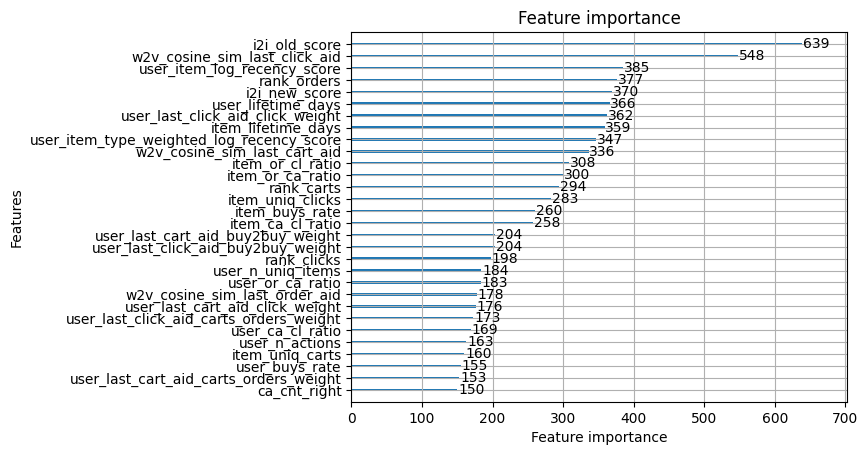

In [115]:
lgb.plot_importance(gbm_ranking, max_num_features=30)

In [123]:
0.1 * 0.5155 + 0.3 * 0.4114 + 0.6 * 0.6575 + 0.0206

0.5900699999999999

#### candidates covisit top200 all types - orders, carts, clicks (CV orders 0.6551)
#### candidates covisit top200 all types - orders, carts, clicks + i2i top100 (CV orders 0.6557)
#### candidates covisit top200 all types - orders, carts, clicks + i2i top100, features item_time_distribution (CV orders 0.6557)

In [124]:
feature_cols = df_stage_2_dataset_train.drop(["session", "aid", "target"]).columns
feature_cols

['rank_orders',
 'rank_carts',
 'rank_clicks',
 'i2i_score',
 'user_last_click_aid_carts_orders_weight',
 'user_last_click_aid_buy2buy_weight',
 'user_last_click_aid_click_weight',
 'user_last_cart_aid_carts_orders_weight',
 'user_last_cart_aid_buy2buy_weight',
 'user_last_cart_aid_click_weight',
 'user_last_order_aid_carts_orders_weight',
 'user_last_order_aid_buy2buy_weight',
 'user_last_order_aid_click_weight',
 'user_lifetime_days',
 'user_n_actions',
 'user_n_uniq_items',
 'user_buys_rate',
 'user_uniq_clicks',
 'user_uniq_carts',
 'user_uniq_orders',
 'cl_cnt',
 'ca_cnt',
 'or_cnt',
 'user_ca_cl_ratio',
 'user_or_cl_ratio',
 'user_or_ca_ratio',
 'item_lifetime_days',
 'item_n_actions',
 'item_n_uniq_users',
 'item_buys_rate',
 'item_uniq_clicks',
 'item_uniq_carts',
 'item_uniq_orders',
 'cl_cnt_right',
 'ca_cnt_right',
 'or_cnt_right',
 'item_ca_cl_ratio',
 'item_or_cl_ratio',
 'item_or_ca_ratio',
 'item_hm_mean',
 'item_hm_median',
 'item_hm_std',
 'item_day0cnt',
 'item_day1cn

In [126]:
skf = GroupKFold(n_splits=5)
df_valid_preds = df_stage_2_dataset_train.select(["session", "aid"])

for fold, (train_idx, valid_idx) in tqdm(enumerate(
    skf.split(df_stage_2_dataset_train,
              df_stage_2_dataset_train['target'],
              groups=df_stage_2_dataset_train['session'])
)):
    
    X_train = df_stage_2_dataset_train[train_idx][feature_cols].to_pandas()
    y_train = df_stage_2_dataset_train[train_idx]["target"].to_pandas()
    X_valid = df_stage_2_dataset_train[valid_idx][feature_cols].to_pandas()
    y_valid = df_stage_2_dataset_train[valid_idx]["target"].to_pandas()
    
    # create dataset for lightgbm
    groups_len_train = (
        df_stage_2_dataset_train[train_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )
    groups_len_valid = (
        df_stage_2_dataset_train[valid_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )    
    lgb_train = lgb.Dataset(X_train, y_train, group=groups_len_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, group=groups_len_valid, reference=lgb_train)
    
    # train model
    gbm_ranking = lgb.train(
        params, 
        lgb_train,
        num_boost_round=2000,
#         return_cvbooster=True,
        feval=lgb_numba_recall,
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=20)]
    )
    
    scores = gbm_ranking.predict(X_valid)
    df_valid_preds_fold = (
        df_stage_2_dataset_train[valid_idx].select(["session", "aid"])
        .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
    )
    df_valid_preds = (
        df_valid_preds.join(df_valid_preds_fold, on=["session", "aid"], how="left")
    )
    
    # add save models
    gbm_ranking.save_model(f"__model__orders_covisit_all_types_merged_top200+i2i_k=100_top100_reranker_rank+i2i_score+75feat_fold{fold}.lgb")

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.914616
[40]	valid_0's numba_recall@20: 0.918132
[60]	valid_0's numba_recall@20: 0.920183
[80]	valid_0's numba_recall@20: 0.921843
[100]	valid_0's numba_recall@20: 0.922624
[120]	valid_0's numba_recall@20: 0.923015
[140]	valid_0's numba_recall@20: 0.92321
[160]	valid_0's numba_recall@20: 0.923381
[180]	valid_0's numba_recall@20: 0.923674
[200]	valid_0's numba_recall@20: 0.92365
[220]	valid_0's numba_recall@20: 0.923381
[240]	valid_0's numba_recall@20: 0.923845
[260]	valid_0's numba_recall@20: 0.923772
[280]	valid_0's numba_recall@20: 0.92404
[300]	valid_0's numba_recall@20: 0.924163
[320]	valid_0's numba_recall@20: 0.92404
[340]	valid_0's numba_recall@20: 0.923821
[360]	valid_0's numba_recall@20: 0.923772
[380]	valid_0's numba_recall@20: 0.923772
[400]	valid_0's numba_recall@20: 0.923699
Early stopping, best iteration is:
[301]	valid_0's numba_recall@20: 0.924211


1it [03:18, 198.40s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.913055
[40]	valid_0's numba_recall@20: 0.916656
[60]	valid_0's numba_recall@20: 0.91842
[80]	valid_0's numba_recall@20: 0.919106
[100]	valid_0's numba_recall@20: 0.920062
[120]	valid_0's numba_recall@20: 0.920576
[140]	valid_0's numba_recall@20: 0.921115
[160]	valid_0's numba_recall@20: 0.921532
[180]	valid_0's numba_recall@20: 0.921311
[200]	valid_0's numba_recall@20: 0.921409
[220]	valid_0's numba_recall@20: 0.921556
[240]	valid_0's numba_recall@20: 0.921434
[260]	valid_0's numba_recall@20: 0.921336
[280]	valid_0's numba_recall@20: 0.921262
[300]	valid_0's numba_recall@20: 0.921581
[320]	valid_0's numba_recall@20: 0.921311
[340]	valid_0's numba_recall@20: 0.92163
[360]	valid_0's numba_recall@20: 0.921605
[380]	valid_0's numba_recall@20: 0.921654
[400]	valid_0's numba_recall@20: 0.921483
[420]	valid_0's numba_recall@20: 0.921336
[440]	valid_0's numba_recall@20: 0.92114
[460]	valid_0's numba

2it [07:08, 217.00s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.913106
[40]	valid_0's numba_recall@20: 0.915637
[60]	valid_0's numba_recall@20: 0.918386
[80]	valid_0's numba_recall@20: 0.920065
[100]	valid_0's numba_recall@20: 0.921233
[120]	valid_0's numba_recall@20: 0.921355
[140]	valid_0's numba_recall@20: 0.921817
[160]	valid_0's numba_recall@20: 0.921915
[180]	valid_0's numba_recall@20: 0.922158
[200]	valid_0's numba_recall@20: 0.922377
[220]	valid_0's numba_recall@20: 0.922377
[240]	valid_0's numba_recall@20: 0.92245
[260]	valid_0's numba_recall@20: 0.922596
[280]	valid_0's numba_recall@20: 0.922401
[300]	valid_0's numba_recall@20: 0.92245
[320]	valid_0's numba_recall@20: 0.922669
[340]	valid_0's numba_recall@20: 0.922572
[360]	valid_0's numba_recall@20: 0.922426
[380]	valid_0's numba_recall@20: 0.922353
[400]	valid_0's numba_recall@20: 0.922353
Early stopping, best iteration is:
[319]	valid_0's numba_recall@20: 0.922669


3it [10:35, 212.37s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.913196
[40]	valid_0's numba_recall@20: 0.916443
[60]	valid_0's numba_recall@20: 0.918313
[80]	valid_0's numba_recall@20: 0.919297
[100]	valid_0's numba_recall@20: 0.919715
[120]	valid_0's numba_recall@20: 0.920084
[140]	valid_0's numba_recall@20: 0.920895
[160]	valid_0's numba_recall@20: 0.921215
[180]	valid_0's numba_recall@20: 0.921264
[200]	valid_0's numba_recall@20: 0.921166
[220]	valid_0's numba_recall@20: 0.921338
[240]	valid_0's numba_recall@20: 0.921215
[260]	valid_0's numba_recall@20: 0.921215
[280]	valid_0's numba_recall@20: 0.921436
[300]	valid_0's numba_recall@20: 0.921461
[320]	valid_0's numba_recall@20: 0.92151
[340]	valid_0's numba_recall@20: 0.921559
[360]	valid_0's numba_recall@20: 0.921682
[380]	valid_0's numba_recall@20: 0.921535
[400]	valid_0's numba_recall@20: 0.921707
[420]	valid_0's numba_recall@20: 0.921289
[440]	valid_0's numba_recall@20: 0.921461
[460]	valid_0's num

4it [14:36, 223.66s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.915362
[40]	valid_0's numba_recall@20: 0.917177
[60]	valid_0's numba_recall@20: 0.919281
[80]	valid_0's numba_recall@20: 0.920152
[100]	valid_0's numba_recall@20: 0.920926
[120]	valid_0's numba_recall@20: 0.921386
[140]	valid_0's numba_recall@20: 0.921555
[160]	valid_0's numba_recall@20: 0.921918
[180]	valid_0's numba_recall@20: 0.921918
[200]	valid_0's numba_recall@20: 0.921942
[220]	valid_0's numba_recall@20: 0.922184
[240]	valid_0's numba_recall@20: 0.922232
[260]	valid_0's numba_recall@20: 0.92245
[280]	valid_0's numba_recall@20: 0.922353
[300]	valid_0's numba_recall@20: 0.922208
[320]	valid_0's numba_recall@20: 0.922281
[340]	valid_0's numba_recall@20: 0.922498
[360]	valid_0's numba_recall@20: 0.922232
[380]	valid_0's numba_recall@20: 0.922184
[400]	valid_0's numba_recall@20: 0.92216
[420]	valid_0's numba_recall@20: 0.92216
Early stopping, best iteration is:
[331]	valid_0's numba_recall

5it [18:07, 217.52s/it]


In [127]:
_ = calc_oof_score_for_type(df_valid_preds, act_type="orders")

100%|██████████| 134666/134666 [00:00<00:00, 273507.61it/s]


validation score: 0.3934185330114062
recall per type: type
orders   0.6557
dtype: float64


#### candidates covisit top200 + feature i2i_score (CV orders 0.6527)

In [45]:
feature_cols = df_stage_2_dataset_train.drop(["session", "aid", "target"]).columns
feature_cols

['rank',
 'i2i_score',
 'user_last_click_aid_carts_orders_weight',
 'user_last_click_aid_buy2buy_weight',
 'user_last_click_aid_click_weight',
 'user_last_cart_aid_carts_orders_weight',
 'user_last_cart_aid_buy2buy_weight',
 'user_last_cart_aid_click_weight',
 'user_last_order_aid_carts_orders_weight',
 'user_last_order_aid_buy2buy_weight',
 'user_last_order_aid_click_weight',
 'user_lifetime_days',
 'user_n_actions',
 'user_n_uniq_items',
 'user_buys_rate',
 'user_uniq_clicks',
 'user_uniq_carts',
 'user_uniq_orders',
 'cl_cnt',
 'ca_cnt',
 'or_cnt',
 'user_ca_cl_ratio',
 'user_or_cl_ratio',
 'user_or_ca_ratio',
 'item_lifetime_days',
 'item_n_actions',
 'item_n_uniq_users',
 'item_buys_rate',
 'item_uniq_clicks',
 'item_uniq_carts',
 'item_uniq_orders',
 'cl_cnt_right',
 'ca_cnt_right',
 'or_cnt_right',
 'item_ca_cl_ratio',
 'item_or_cl_ratio',
 'item_or_ca_ratio',
 'item_n_sess_multi_clicks',
 'item_n_sess_multi_carts',
 'item_n_sess_multi_buys',
 'user_item_log_recency_score',
 'us

In [62]:
skf = GroupKFold(n_splits=5)
df_valid_preds = df_stage_2_dataset_train.filter(pl.col("rank") != 999).select(["session", "aid"])

for fold, (train_idx, valid_idx) in tqdm(enumerate(
    skf.split(df_stage_2_dataset_train.filter(pl.col("rank") != 999),
              df_stage_2_dataset_train.filter(pl.col("rank") != 999)['target'],
              groups=df_stage_2_dataset_train.filter(pl.col("rank") != 999)['session'])
)):
    
    X_train = df_stage_2_dataset_train.filter(pl.col("rank") != 999)[train_idx][feature_cols].to_pandas()
    y_train = df_stage_2_dataset_train.filter(pl.col("rank") != 999)[train_idx]["target"].to_pandas()
    X_valid = df_stage_2_dataset_train.filter(pl.col("rank") != 999)[valid_idx][feature_cols].to_pandas()
    y_valid = df_stage_2_dataset_train.filter(pl.col("rank") != 999)[valid_idx]["target"].to_pandas()
    
    # create dataset for lightgbm
    groups_len_train = (
        df_stage_2_dataset_train.filter(pl.col("rank") != 999)[train_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )
    groups_len_valid = (
        df_stage_2_dataset_train.filter(pl.col("rank") != 999)[valid_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )    
    lgb_train = lgb.Dataset(X_train, y_train, group=groups_len_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, group=groups_len_valid, reference=lgb_train)
    
    # train model
    gbm_ranking = lgb.train(
        params, 
        lgb_train,
        num_boost_round=2000,
#         return_cvbooster=True,
        feval=lgb_numba_recall,
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=20)]
    )
    
    scores = gbm_ranking.predict(X_valid)
    df_valid_preds_fold = (
        df_stage_2_dataset_train.filter(pl.col("rank") != 999)[valid_idx].select(["session", "aid"])
        .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
    )
    df_valid_preds = (
        df_valid_preds.join(df_valid_preds_fold, on=["session", "aid"], how="left")
    )
    
    # add save models
    gbm_ranking.save_model(f"__model__orders_covisit_top200_reranker_rank+i2i_score+42feat_fold{fold}.lgb")

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.934269
[40]	valid_0's numba_recall@20: 0.937264
[60]	valid_0's numba_recall@20: 0.938388
[80]	valid_0's numba_recall@20: 0.939436
[100]	valid_0's numba_recall@20: 0.939062
[120]	valid_0's numba_recall@20: 0.939836
[140]	valid_0's numba_recall@20: 0.940335
[160]	valid_0's numba_recall@20: 0.94061
[180]	valid_0's numba_recall@20: 0.940335
[200]	valid_0's numba_recall@20: 0.94051
[220]	valid_0's numba_recall@20: 0.940485
[240]	valid_0's numba_recall@20: 0.940485
[260]	valid_0's numba_recall@20: 0.940734
[280]	valid_0's numba_recall@20: 0.94051
[300]	valid_0's numba_recall@20: 0.940635
[320]	valid_0's numba_recall@20: 0.940784
[340]	valid_0's numba_recall@20: 0.940884
[360]	valid_0's numba_recall@20: 0.940909
[380]	valid_0's numba_recall@20: 0.940909
[400]	valid_0's numba_recall@20: 0.941059
[420]	valid_0's numba_recall@20: 0.940984
[440]	valid_0's numba_recall@20: 0.941259
[460]	valid_0's numba

1it [01:55, 115.98s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.932607
[40]	valid_0's numba_recall@20: 0.935375
[60]	valid_0's numba_recall@20: 0.936373
[80]	valid_0's numba_recall@20: 0.936996
[100]	valid_0's numba_recall@20: 0.937371
[120]	valid_0's numba_recall@20: 0.937845
[140]	valid_0's numba_recall@20: 0.937845
[160]	valid_0's numba_recall@20: 0.938219
[180]	valid_0's numba_recall@20: 0.938518
[200]	valid_0's numba_recall@20: 0.938493
[220]	valid_0's numba_recall@20: 0.938792
[240]	valid_0's numba_recall@20: 0.938593
[260]	valid_0's numba_recall@20: 0.938817
[280]	valid_0's numba_recall@20: 0.938693
[300]	valid_0's numba_recall@20: 0.938892
[320]	valid_0's numba_recall@20: 0.938817
[340]	valid_0's numba_recall@20: 0.938842
[360]	valid_0's numba_recall@20: 0.938967
[380]	valid_0's numba_recall@20: 0.938992
[400]	valid_0's numba_recall@20: 0.938867
[420]	valid_0's numba_recall@20: 0.938942
[440]	valid_0's numba_recall@20: 0.938742
[460]	valid_0's nu

2it [03:30, 103.64s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.935047
[40]	valid_0's numba_recall@20: 0.938003
[60]	valid_0's numba_recall@20: 0.939656
[80]	valid_0's numba_recall@20: 0.940683
[100]	valid_0's numba_recall@20: 0.940733
[120]	valid_0's numba_recall@20: 0.941234
[140]	valid_0's numba_recall@20: 0.94171
[160]	valid_0's numba_recall@20: 0.941785
[180]	valid_0's numba_recall@20: 0.94171
[200]	valid_0's numba_recall@20: 0.942111
[220]	valid_0's numba_recall@20: 0.942361
[240]	valid_0's numba_recall@20: 0.942261
[260]	valid_0's numba_recall@20: 0.942511
[280]	valid_0's numba_recall@20: 0.942612
[300]	valid_0's numba_recall@20: 0.942612
[320]	valid_0's numba_recall@20: 0.942511
[340]	valid_0's numba_recall@20: 0.942511
[360]	valid_0's numba_recall@20: 0.942562
Early stopping, best iteration is:
[269]	valid_0's numba_recall@20: 0.942712


3it [04:47, 91.21s/it] 

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.934927
[40]	valid_0's numba_recall@20: 0.937098
[60]	valid_0's numba_recall@20: 0.939144
[80]	valid_0's numba_recall@20: 0.939718
[100]	valid_0's numba_recall@20: 0.940192
[120]	valid_0's numba_recall@20: 0.940466
[140]	valid_0's numba_recall@20: 0.940691
[160]	valid_0's numba_recall@20: 0.941065
[180]	valid_0's numba_recall@20: 0.94109
[200]	valid_0's numba_recall@20: 0.94094
[220]	valid_0's numba_recall@20: 0.940865
[240]	valid_0's numba_recall@20: 0.94114
[260]	valid_0's numba_recall@20: 0.941314
[280]	valid_0's numba_recall@20: 0.941115
[300]	valid_0's numba_recall@20: 0.941015
[320]	valid_0's numba_recall@20: 0.94109
[340]	valid_0's numba_recall@20: 0.94094
Early stopping, best iteration is:
[257]	valid_0's numba_recall@20: 0.941339


4it [06:01, 84.47s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.932109
[40]	valid_0's numba_recall@20: 0.934718
[60]	valid_0's numba_recall@20: 0.936525
[80]	valid_0's numba_recall@20: 0.937052
[100]	valid_0's numba_recall@20: 0.937654
[120]	valid_0's numba_recall@20: 0.93808
[140]	valid_0's numba_recall@20: 0.938206
[160]	valid_0's numba_recall@20: 0.938181
[180]	valid_0's numba_recall@20: 0.938306
[200]	valid_0's numba_recall@20: 0.938256
[220]	valid_0's numba_recall@20: 0.938206
[240]	valid_0's numba_recall@20: 0.938482
[260]	valid_0's numba_recall@20: 0.938532
[280]	valid_0's numba_recall@20: 0.938381
[300]	valid_0's numba_recall@20: 0.938406
[320]	valid_0's numba_recall@20: 0.938758
[340]	valid_0's numba_recall@20: 0.938808
[360]	valid_0's numba_recall@20: 0.938657
[380]	valid_0's numba_recall@20: 0.938632
[400]	valid_0's numba_recall@20: 0.938507
[420]	valid_0's numba_recall@20: 0.938582
Early stopping, best iteration is:
[329]	valid_0's numba_reca

5it [07:28, 89.80s/it]


#### candidates covisit top200, i2i candidates K=100 top100 + features i2i_score (CV orders 0.6539) BEST!

In [48]:
skf = GroupKFold(n_splits=5)
df_valid_preds = df_stage_2_dataset_train.select(["session", "aid"])

for fold, (train_idx, valid_idx) in tqdm(enumerate(
    skf.split(df_stage_2_dataset_train,
              df_stage_2_dataset_train['target'],
              groups=df_stage_2_dataset_train['session'])
)):
    
    X_train = df_stage_2_dataset_train[train_idx][feature_cols].to_pandas()
    y_train = df_stage_2_dataset_train[train_idx]["target"].to_pandas()
    X_valid = df_stage_2_dataset_train[valid_idx][feature_cols].to_pandas()
    y_valid = df_stage_2_dataset_train[valid_idx]["target"].to_pandas()
    
    # create dataset for lightgbm
    groups_len_train = (
        df_stage_2_dataset_train[train_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )
    groups_len_valid = (
        df_stage_2_dataset_train[valid_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )    
    lgb_train = lgb.Dataset(X_train, y_train, group=groups_len_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, group=groups_len_valid, reference=lgb_train)
    
    # train model
    gbm_ranking = lgb.train(
        params, 
        lgb_train,
        num_boost_round=2000,
#         return_cvbooster=True,
        feval=lgb_numba_recall,
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=20)]
    )
    
    scores = gbm_ranking.predict(X_valid)
    df_valid_preds_fold = (
        df_stage_2_dataset_train[valid_idx].select(["session", "aid"])
        .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
    )
    df_valid_preds = (
        df_valid_preds.join(df_valid_preds_fold, on=["session", "aid"], how="left")
    )
    
    # add save models
    gbm_ranking.save_model(f"__model__orders_covisit_top200+i2i_k=100_top100_reranker_rank+42feat_fold{fold}.lgb")

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.921154
[40]	valid_0's numba_recall@20: 0.923039
[60]	valid_0's numba_recall@20: 0.924155
[80]	valid_0's numba_recall@20: 0.925618
[100]	valid_0's numba_recall@20: 0.92599
[120]	valid_0's numba_recall@20: 0.926486
[140]	valid_0's numba_recall@20: 0.926908
[160]	valid_0's numba_recall@20: 0.927503
[180]	valid_0's numba_recall@20: 0.927454
[200]	valid_0's numba_recall@20: 0.927354
[220]	valid_0's numba_recall@20: 0.927702
[240]	valid_0's numba_recall@20: 0.927652
[260]	valid_0's numba_recall@20: 0.927751
[280]	valid_0's numba_recall@20: 0.92785
[300]	valid_0's numba_recall@20: 0.927875
[320]	valid_0's numba_recall@20: 0.927677
[340]	valid_0's numba_recall@20: 0.927826
[360]	valid_0's numba_recall@20: 0.927875
[380]	valid_0's numba_recall@20: 0.927776
Early stopping, best iteration is:
[287]	valid_0's numba_recall@20: 0.928074


1it [02:28, 148.63s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.920184
[40]	valid_0's numba_recall@20: 0.921416
[60]	valid_0's numba_recall@20: 0.923533
[80]	valid_0's numba_recall@20: 0.924888
[100]	valid_0's numba_recall@20: 0.925799
[120]	valid_0's numba_recall@20: 0.926292
[140]	valid_0's numba_recall@20: 0.926439
[160]	valid_0's numba_recall@20: 0.926661
[180]	valid_0's numba_recall@20: 0.926661
[200]	valid_0's numba_recall@20: 0.92676
[220]	valid_0's numba_recall@20: 0.926735
[240]	valid_0's numba_recall@20: 0.927006
[260]	valid_0's numba_recall@20: 0.927006
[280]	valid_0's numba_recall@20: 0.927572
[300]	valid_0's numba_recall@20: 0.927572
[320]	valid_0's numba_recall@20: 0.927597
[340]	valid_0's numba_recall@20: 0.927572
[360]	valid_0's numba_recall@20: 0.927548
[380]	valid_0's numba_recall@20: 0.927498
[400]	valid_0's numba_recall@20: 0.927572
Early stopping, best iteration is:
[309]	valid_0's numba_recall@20: 0.927843


2it [05:02, 151.42s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.920346
[40]	valid_0's numba_recall@20: 0.922772
[60]	valid_0's numba_recall@20: 0.924046
[80]	valid_0's numba_recall@20: 0.925295
[100]	valid_0's numba_recall@20: 0.926202
[120]	valid_0's numba_recall@20: 0.926912
[140]	valid_0's numba_recall@20: 0.926937
[160]	valid_0's numba_recall@20: 0.92728
[180]	valid_0's numba_recall@20: 0.927427
[200]	valid_0's numba_recall@20: 0.927647
[220]	valid_0's numba_recall@20: 0.927647
[240]	valid_0's numba_recall@20: 0.927819
[260]	valid_0's numba_recall@20: 0.92826
[280]	valid_0's numba_recall@20: 0.928162
[300]	valid_0's numba_recall@20: 0.928431
[320]	valid_0's numba_recall@20: 0.928407
[340]	valid_0's numba_recall@20: 0.928554
[360]	valid_0's numba_recall@20: 0.928603
[380]	valid_0's numba_recall@20: 0.928676
[400]	valid_0's numba_recall@20: 0.928603
[420]	valid_0's numba_recall@20: 0.928603
[440]	valid_0's numba_recall@20: 0.928676
[460]	valid_0's numb

3it [08:58, 190.46s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.923564
[40]	valid_0's numba_recall@20: 0.925716
[60]	valid_0's numba_recall@20: 0.927695
[80]	valid_0's numba_recall@20: 0.928561
[100]	valid_0's numba_recall@20: 0.929278
[120]	valid_0's numba_recall@20: 0.929575
[140]	valid_0's numba_recall@20: 0.929451
[160]	valid_0's numba_recall@20: 0.929897
[180]	valid_0's numba_recall@20: 0.929946
[200]	valid_0's numba_recall@20: 0.929946
[220]	valid_0's numba_recall@20: 0.93049
[240]	valid_0's numba_recall@20: 0.930367
[260]	valid_0's numba_recall@20: 0.93007
[280]	valid_0's numba_recall@20: 0.93007
[300]	valid_0's numba_recall@20: 0.930292
[320]	valid_0's numba_recall@20: 0.930342
Early stopping, best iteration is:
[220]	valid_0's numba_recall@20: 0.93049


4it [11:00, 163.32s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.922231
[40]	valid_0's numba_recall@20: 0.924441
[60]	valid_0's numba_recall@20: 0.92616
[80]	valid_0's numba_recall@20: 0.927289
[100]	valid_0's numba_recall@20: 0.927879
[120]	valid_0's numba_recall@20: 0.928443
[140]	valid_0's numba_recall@20: 0.928566
[160]	valid_0's numba_recall@20: 0.928689
[180]	valid_0's numba_recall@20: 0.928615
[200]	valid_0's numba_recall@20: 0.928591
[220]	valid_0's numba_recall@20: 0.928763
[240]	valid_0's numba_recall@20: 0.928812
[260]	valid_0's numba_recall@20: 0.928959
[280]	valid_0's numba_recall@20: 0.928984
[300]	valid_0's numba_recall@20: 0.928836
[320]	valid_0's numba_recall@20: 0.929303
[340]	valid_0's numba_recall@20: 0.929205
[360]	valid_0's numba_recall@20: 0.928787
[380]	valid_0's numba_recall@20: 0.929106
[400]	valid_0's numba_recall@20: 0.928959
Early stopping, best iteration is:
[319]	valid_0's numba_recall@20: 0.929327


5it [13:34, 163.00s/it]


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

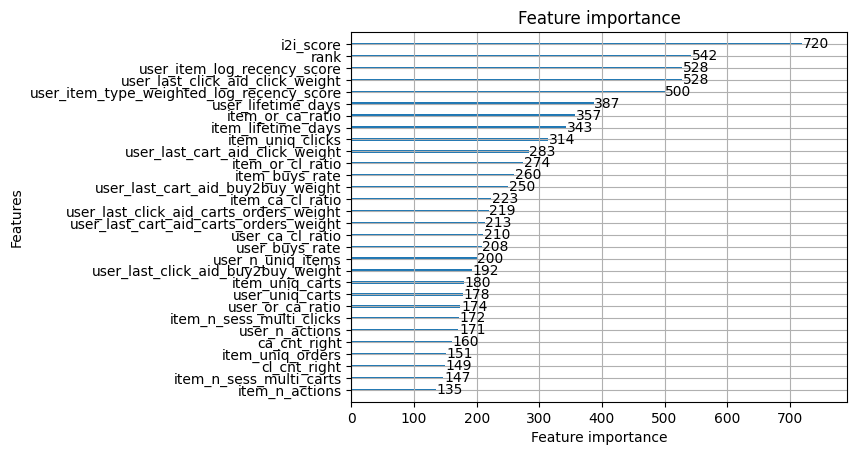

In [54]:
lgb.plot_importance(gbm_ranking, max_num_features=30)

#### candidates covisitation top200 (CURRENT LAST SUBMITTED)

In [167]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
#     'objective': 'binary',
    'objective': 'lambdarank',
    'metric': '"None"',
    'eval_at': 20,
#     'metric': {'auc', 'binary_logloss'},
#     'min_data_in_leaf': 256, 
#     'num_leaves': 63,
    'max_depth': 7,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'device': 'gpu',
    'verbose': -1,
    'num_threads': 40,
}

In [168]:
feature_cols = ["rank"] + df_stage_2_dataset_train.columns[4:]
feature_cols

['rank',
 'user_last_click_aid_carts_orders_weight',
 'user_last_click_aid_buy2buy_weight',
 'user_last_click_aid_click_weight',
 'user_last_cart_aid_carts_orders_weight',
 'user_last_cart_aid_buy2buy_weight',
 'user_last_cart_aid_click_weight',
 'user_last_order_aid_carts_orders_weight',
 'user_last_order_aid_buy2buy_weight',
 'user_last_order_aid_click_weight',
 'user_lifetime_days',
 'user_n_actions',
 'user_n_uniq_items',
 'user_buys_rate',
 'user_uniq_clicks',
 'user_uniq_carts',
 'user_uniq_orders',
 'cl_cnt',
 'ca_cnt',
 'or_cnt',
 'user_ca_cl_ratio',
 'user_or_cl_ratio',
 'user_or_ca_ratio',
 'item_lifetime_days',
 'item_n_actions',
 'item_n_uniq_users',
 'item_buys_rate',
 'item_uniq_clicks',
 'item_uniq_carts',
 'item_uniq_orders',
 'cl_cnt_right',
 'ca_cnt_right',
 'or_cnt_right',
 'item_ca_cl_ratio',
 'item_or_cl_ratio',
 'item_or_ca_ratio',
 'item_n_sess_multi_clicks',
 'item_n_sess_multi_carts',
 'item_n_sess_multi_buys',
 'user_item_log_recency_score',
 'user_item_type_w

In [169]:
skf = GroupKFold(n_splits=5)

df_valid_preds = df_stage_2_dataset_for_pred.select(["session", "aid"]).unique()

for fold, (train_idx, valid_idx) in tqdm(enumerate(
    skf.split(df_stage_2_dataset_train,
              df_stage_2_dataset_train['target'],
              groups=df_stage_2_dataset_train['session'])
)):
    
    X_train = df_stage_2_dataset_train[train_idx][feature_cols].to_pandas()
    y_train = df_stage_2_dataset_train[train_idx]["target"].to_pandas()
    X_valid = df_stage_2_dataset_train[valid_idx][feature_cols].to_pandas()
    y_valid = df_stage_2_dataset_train[valid_idx]["target"].to_pandas()
    
    # create dataset for lightgbm
    groups_len_train = (
        df_stage_2_dataset_train[train_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )
    groups_len_valid = (
        df_stage_2_dataset_train[valid_idx]
        .groupby("session").agg(pl.count("aid"))
        .sort("session")["aid"].to_numpy()
    )    
    lgb_train = lgb.Dataset(X_train, y_train, group=groups_len_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, group=groups_len_valid, reference=lgb_train)
    
    # train model
    gbm_ranking = lgb.train(
        params, 
        lgb_train,
        num_boost_round=2000,
#         return_cvbooster=True,
        feval=lgb_numba_recall,
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=20)]
    )
    
    # predict scores for remained pred period - to handle leakage
#     X_test = (
#         df_stage_2_dataset_for_pred
#         .join(
#             df_stage_2_dataset_train[train_idx].select(["session", "aid", pl.lit(1).alias("is_train")]),
#             on=["session", "aid"],
#             how="left"
#         )
#         .filter(pl.col("is_train").is_null())
#         .drop("is_train")
#     )
    
#     scores = gbm_ranking.predict(X_test[:, 2:].to_pandas())
    
    scores = gbm_ranking.predict(X_valid)
#     df_valid_preds_fold = (
#         X_test.select(["session", "aid"])
#         .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
#     )
    df_valid_preds_fold = (
        df_stage_2_dataset_train[valid_idx].select(["session", "aid"])
        .with_columns([pl.Series(scores).alias(f"scores_fold{fold}")])
    )
    df_valid_preds = (
        df_valid_preds.join(df_valid_preds_fold, on=["session", "aid"], how="left")
    )
    
    # add save models
    gbm_ranking.save_model(f"__model__orders_covisit_top200_reranker_rank+44feat_fold{fold}.lgb")

0it [00:00, ?it/s]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.93327
[40]	valid_0's numba_recall@20: 0.93684
[60]	valid_0's numba_recall@20: 0.937839
[80]	valid_0's numba_recall@20: 0.938088
[100]	valid_0's numba_recall@20: 0.939012
[120]	valid_0's numba_recall@20: 0.939187
[140]	valid_0's numba_recall@20: 0.939636
[160]	valid_0's numba_recall@20: 0.939886
[180]	valid_0's numba_recall@20: 0.939836
[200]	valid_0's numba_recall@20: 0.939711
[220]	valid_0's numba_recall@20: 0.940285
[240]	valid_0's numba_recall@20: 0.940335
[260]	valid_0's numba_recall@20: 0.940535
[280]	valid_0's numba_recall@20: 0.940535
[300]	valid_0's numba_recall@20: 0.940734
[320]	valid_0's numba_recall@20: 0.940834
[340]	valid_0's numba_recall@20: 0.941009
[360]	valid_0's numba_recall@20: 0.941009
[380]	valid_0's numba_recall@20: 0.941084
[400]	valid_0's numba_recall@20: 0.941084
[420]	valid_0's numba_recall@20: 0.940859
[440]	valid_0's numba_recall@20: 0.940959
[460]	valid_0's numb

1it [01:54, 114.44s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.932033
[40]	valid_0's numba_recall@20: 0.934876
[60]	valid_0's numba_recall@20: 0.936049
[80]	valid_0's numba_recall@20: 0.936947
[100]	valid_0's numba_recall@20: 0.937445
[120]	valid_0's numba_recall@20: 0.937545
[140]	valid_0's numba_recall@20: 0.938144
[160]	valid_0's numba_recall@20: 0.938293
[180]	valid_0's numba_recall@20: 0.938144
[200]	valid_0's numba_recall@20: 0.938044
[220]	valid_0's numba_recall@20: 0.938194
[240]	valid_0's numba_recall@20: 0.938318
[260]	valid_0's numba_recall@20: 0.938518
[280]	valid_0's numba_recall@20: 0.938643
[300]	valid_0's numba_recall@20: 0.938568
[320]	valid_0's numba_recall@20: 0.938593
[340]	valid_0's numba_recall@20: 0.938693
[360]	valid_0's numba_recall@20: 0.938418
[380]	valid_0's numba_recall@20: 0.938742
[400]	valid_0's numba_recall@20: 0.938992
[420]	valid_0's numba_recall@20: 0.939117
[440]	valid_0's numba_recall@20: 0.939017
[460]	valid_0's nu

2it [04:02, 122.17s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.93407
[40]	valid_0's numba_recall@20: 0.937602
[60]	valid_0's numba_recall@20: 0.939205
[80]	valid_0's numba_recall@20: 0.939681
[100]	valid_0's numba_recall@20: 0.939931
[120]	valid_0's numba_recall@20: 0.940182
[140]	valid_0's numba_recall@20: 0.940633
[160]	valid_0's numba_recall@20: 0.940908
[180]	valid_0's numba_recall@20: 0.940908
[200]	valid_0's numba_recall@20: 0.940933
[220]	valid_0's numba_recall@20: 0.940858
[240]	valid_0's numba_recall@20: 0.940958
[260]	valid_0's numba_recall@20: 0.941084
[280]	valid_0's numba_recall@20: 0.941159
[300]	valid_0's numba_recall@20: 0.941259
[320]	valid_0's numba_recall@20: 0.941359
[340]	valid_0's numba_recall@20: 0.941434
[360]	valid_0's numba_recall@20: 0.941685
[380]	valid_0's numba_recall@20: 0.941635
[400]	valid_0's numba_recall@20: 0.94181
[420]	valid_0's numba_recall@20: 0.94181
[440]	valid_0's numba_recall@20: 0.94186
[460]	valid_0's numba_

3it [05:46, 114.23s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.933704
[40]	valid_0's numba_recall@20: 0.937497
[60]	valid_0's numba_recall@20: 0.938245
[80]	valid_0's numba_recall@20: 0.938719
[100]	valid_0's numba_recall@20: 0.938869
[120]	valid_0's numba_recall@20: 0.939194
[140]	valid_0's numba_recall@20: 0.939668
[160]	valid_0's numba_recall@20: 0.939767
[180]	valid_0's numba_recall@20: 0.939693
[200]	valid_0's numba_recall@20: 0.940067
[220]	valid_0's numba_recall@20: 0.940067
[240]	valid_0's numba_recall@20: 0.939967
[260]	valid_0's numba_recall@20: 0.939992
[280]	valid_0's numba_recall@20: 0.939892
[300]	valid_0's numba_recall@20: 0.940266
[320]	valid_0's numba_recall@20: 0.940491
[340]	valid_0's numba_recall@20: 0.940566
[360]	valid_0's numba_recall@20: 0.940491
[380]	valid_0's numba_recall@20: 0.940466
[400]	valid_0's numba_recall@20: 0.940516
[420]	valid_0's numba_recall@20: 0.940416
[440]	valid_0's numba_recall@20: 0.940516
[460]	valid_0's nu

4it [07:45, 116.14s/it]

Training until validation scores don't improve for 100 rounds
[20]	valid_0's numba_recall@20: 0.931381
[40]	valid_0's numba_recall@20: 0.934844
[60]	valid_0's numba_recall@20: 0.936349
[80]	valid_0's numba_recall@20: 0.936474
[100]	valid_0's numba_recall@20: 0.936826
[120]	valid_0's numba_recall@20: 0.937202
[140]	valid_0's numba_recall@20: 0.937378
[160]	valid_0's numba_recall@20: 0.937478
[180]	valid_0's numba_recall@20: 0.937478
[200]	valid_0's numba_recall@20: 0.937804
[220]	valid_0's numba_recall@20: 0.93803
[240]	valid_0's numba_recall@20: 0.937955
[260]	valid_0's numba_recall@20: 0.938005
[280]	valid_0's numba_recall@20: 0.937829
[300]	valid_0's numba_recall@20: 0.937829
Early stopping, best iteration is:
[211]	valid_0's numba_recall@20: 0.938105


5it [08:47, 105.41s/it]


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

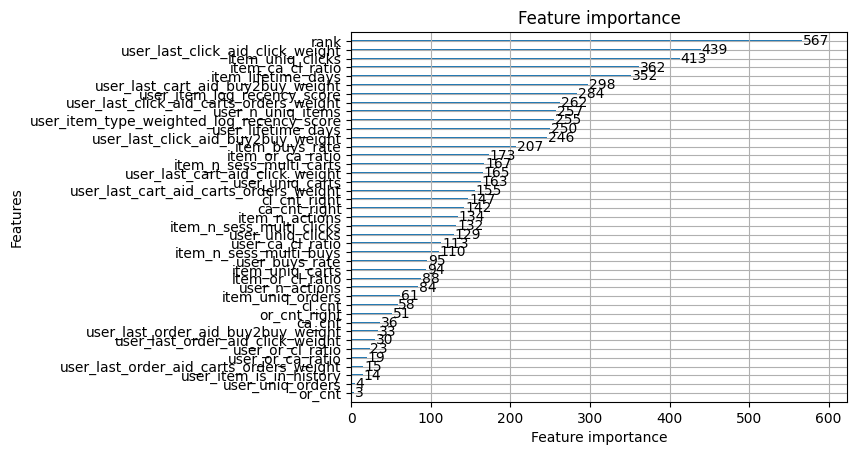

In [145]:
lgb.plot_importance(gbm_ranking)

### Metrics

In [95]:
scores = (
    df_valid_preds
    .select([
        pl.col("scores_fold0"),
        pl.col("scores_fold1"),
        pl.col("scores_fold2"), 
        pl.col("scores_fold3"), 
        pl.col("scores_fold4"),
    ]).mean(axis=1)
)

df_valid_preds_sorted = (
    df_valid_preds
    .with_column(scores.alias("score"))
    .select(["session", "aid", "score"])
    .sort("score", reverse=True)
    .groupby("session")
    .agg([
        pl.list("aid"),
        pl.list("score"),
    ])
)

[autoreload of otto_lgbm_utils failed: Traceback (most recent call last):
  File "/opt/poetry/virtualenvs/tasks-9TtSrW0h-py3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/opt/poetry/virtualenvs/tasks-9TtSrW0h-py3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/usr/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 855, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/app/notebooks/otto/otto_lgbm_utils.py", line 5, in <module>
    from .otto_utils import calc_valid_score
ImportError: attempted relative import with no known parent package
]


In [110]:
print(df_valid_preds_sorted)

shape: (134666, 3)
┌──────────┬───────────────────────────────┬─────────────────────────────────────┐
│ session  ┆ aid                           ┆ score                               │
│ ---      ┆ ---                           ┆ ---                                 │
│ i64      ┆ list[i64]                     ┆ list[f64]                           │
╞══════════╪═══════════════════════════════╪═════════════════════════════════════╡
│ 12309632 ┆ [1246180, 269352, ... 152547] ┆ [4.266326, 4.083894, ... -9.9461... │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 11863488 ┆ [130719, 1144895, ... 33343]  ┆ [5.02638, 0.944651, ... -9.51151... │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 11161600 ┆ [29037, 1729430, ... 33343]   ┆ [3.856204, 2.632893, ... -10.861... │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 12784896 ┆ [227987, 1706202, ... 33343]  ┆ [5.364168, 0.399723, ..

In [96]:
df_valid_preds_sorted

session,aid,score
i64,list[i64],list[f64]
12309632,"[1246180, 269352, ... 152547]","[4.266326, 4.083894, ... -9.946163]"
11863488,"[130719, 1144895, ... 33343]","[5.02638, 0.944651, ... -9.51151]"
11161600,"[29037, 1729430, ... 33343]","[3.856204, 2.632893, ... -10.861369]"
12784896,"[227987, 1706202, ... 33343]","[5.364168, 0.399723, ... -9.181076]"
12256448,"[204263, 1127359, ... 152547]","[2.448543, 0.776582, ... -9.964434]"
11861824,"[685974, 648952, ... 152547]","[4.786785, 1.428266, ... -8.89562]"
11474176,"[134379, 153977, ... 33343]","[5.056815, -0.72975, ... -9.952653]"
12188864,"[1236991, 952614, ... 322370]","[5.082263, -0.021402, ... -10.105209]"
11763904,"[671210, 1598976, ... 152547]","[3.642681, 1.587191, ... -9.632892]"


In [97]:
# stage 2 valid orders reranked - recall@20 optimized
submission_dict = {
    "session_type": [],
    "labels": [],
}

types = ["orders"]
topk = 20

for row in tqdm(df_valid_preds_sorted.rows()):
    session_id = row[0]
    rec_items = row[1][:topk]
    
    session_types = [f"{session_id}_{t}" for t in types]
    labels = " ".join(str(aid) for aid in rec_items)
    labels_list = [labels]
    
    submission_dict["session_type"].extend(session_types)
    submission_dict["labels"].extend(labels_list)

100%|██████████| 134666/134666 [00:00<00:00, 250445.01it/s]


In [99]:
# candidates i2i (top100, K=100) + covisit all (top200), features i2i_score
df_submission_stage_2_valid_orders_reranked = pl.DataFrame(submission_dict)
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_orders_reranked, topk=20)

validation score: 0.3934351844142869
recall per type: type
orders   0.6557
dtype: float64


In [84]:
# candidates covisit all (top200), features i2i_score
df_submission_stage_2_valid_orders_reranked = pl.DataFrame(submission_dict)
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_orders_reranked, topk=20)

validation score: 0.39308550495379235
recall per type: type
orders   0.6551
dtype: float64


In [66]:
# candidates covisit (top200), features i2i_score
df_submission_stage_2_valid_orders_reranked = pl.DataFrame(submission_dict)
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_orders_reranked, topk=20)

validation score: 0.39160353009741067
recall per type: type
orders   0.6527
dtype: float64


In [52]:
# candidates i2i (top100, K=100) + covisit (top200), features i2i_score
df_submission_stage_2_valid_orders_reranked = pl.DataFrame(submission_dict)
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_orders_reranked, topk=20)

validation score: 0.3923216218466406
recall per type: type
orders   0.6539
dtype: float64


In [41]:
df_submission_stage_2_valid_orders_reranked = pl.DataFrame(submission_dict)
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_orders_reranked, topk=20)

validation score: 0.391274664890517
recall per type: type
orders   0.6521
dtype: float64


In [176]:
# orders, recall@20 optimized, full valid
df_submission_stage_2_valid_orders_reranked = pl.DataFrame(submission_dict)
df_submission_stage_2_valid_reranked = (
    df_submission_valid
    .join(df_submission_stage_2_valid_orders_reranked, on="session_type", how="left")
    .with_columns([
        (
            pl.when(pl.col("labels_right").is_null())
            .then(pl.col("labels"))
            .otherwise(pl.col("labels_right"))
        ).alias("labels_final")
    ])
    .select(["session_type", "labels_final"])
    .rename({"labels_final": "labels"})
)

In [90]:
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_reranked, topk=20)

validation score: 0.5352322010735644
recall per type: type
carts    0.3262
clicks   0.5155
orders   0.6430
dtype: float64


In [178]:
# orders, no reranking, only valid with targets
calc_valid_score(
    (
        df_submission_valid
        .with_column(
            (
                df_submission_valid["session_type"].str.split("_").arr[0].cast(int)
            ).alias("session")
        )
        .join(df_stage_2_dataset_train.select(["session"]).unique(), on="session")
        .drop("session")
    ), topk=20
)

validation score: 0.5539901269174999
recall per type: type
carts    0.3797
clicks   0.5426
orders   0.6430
dtype: float64


,session_type,labels,session,type,ground_truth,hits,gt_count
0,11107757_clicks,"[69701, 441214, 1522691, 1777631, 1741724, 135...",11107757,clicks,[],0,0
1,11107757_carts,"[69701, 441214, 1522691, 1777631, 416657, 1285...",11107757,carts,[69701],1,1
2,11107757_orders,"[69701, 441214, 1522691, 1777631, 309323, 4166...",11107757,orders,[69701],1,1
3,11107761_clicks,"[1077259, 1287701, 1835591, 801055, 1158840, 2...",11107761,clicks,[1789315],0,1
4,11107761_carts,"[1077259, 1287701, 1835591, 1158840, 217117, 8...",11107761,carts,"[217117, 240567, 559821, 950341, 1077259, 1287...",7,9
...,...,...,...,...,...,...,...
403993,12899373_carts,"[1766353, 995962, 487949, 461938, 117765, 1123...",12899373,carts,[1844832],1,1
403994,12899373_orders,"[1766353, 995962, 487949, 461938, 516917, 1763...",12899373,orders,[1766353],1,1
403995,12899525_clicks,"[1599360, 1488793, 127479, 996393, 1523205, 40...",12899525,clicks,[],0,0
403996,12899525_carts,"[1599360, 1488793, 127479, 996393, 405179, 152...",12899525,carts,[],0,0


In [179]:
# orders, oof preds, only valid with targets - rank + 42 features, no additional targets
calc_valid_score(
    (
        df_submission_stage_2_valid_reranked
        .with_column(
            (
                df_submission_stage_2_valid_reranked["session_type"].str.split("_").arr[0].cast(int)
            ).alias("session")
        )
        .join(df_stage_2_dataset_train.select(["session"]).unique(), on="session")
        .drop("session")
    ), topk=20
)

validation score: 0.5596349524940547
recall per type: type
carts    0.3797
clicks   0.5426
orders   0.6525
dtype: float64


,session_type,labels,session,type,ground_truth,hits,gt_count
0,11107757_clicks,"[69701, 441214, 1522691, 1777631, 1741724, 135...",11107757,clicks,[],0,0
1,11107757_carts,"[69701, 441214, 1522691, 1777631, 416657, 1285...",11107757,carts,[69701],1,1
2,11107757_orders,"[69701, 441214, 1777631, 721908, 309323, 12856...",11107757,orders,[69701],1,1
3,11107761_clicks,"[1077259, 1287701, 1835591, 801055, 1158840, 2...",11107761,clicks,[1789315],0,1
4,11107761_carts,"[1077259, 1287701, 1835591, 1158840, 217117, 8...",11107761,carts,"[217117, 240567, 559821, 950341, 1077259, 1287...",7,9
...,...,...,...,...,...,...,...
403993,12899373_carts,"[1766353, 995962, 487949, 461938, 117765, 1123...",12899373,carts,[1844832],1,1
403994,12899373_orders,"[1766353, 487949, 516917, 1821135, 461938, 995...",12899373,orders,[1766353],1,1
403995,12899525_clicks,"[1599360, 1488793, 127479, 996393, 1523205, 40...",12899525,clicks,[],0,0
403996,12899525_carts,"[1599360, 1488793, 127479, 996393, 405179, 152...",12899525,carts,[],0,0


In [181]:
df_submission_stage_2_valid_reranked_all = (
    df_submission_valid
    .join(
        pl.concat([
            df_submission_stage_2_valid_carts_reranked,
            df_submission_stage_2_valid_orders_reranked
        ]), 
        on="session_type", how="left"
    )
    .with_columns([
        (
            pl.when(pl.col("labels_right").is_null())
            .then(pl.col("labels"))
            .otherwise(pl.col("labels_right"))
        ).alias("labels_final")
    ])
    .select(["session_type", "labels_final"])
    .rename({"labels_final": "labels"})
)

In [183]:
valid_metrics_stats = calc_valid_score(df_submission_stage_2_valid_reranked_all, topk=20)

validation score: 0.5664316451092883
recall per type: type
carts    0.4114
clicks   0.5155
orders   0.6525
dtype: float64


In [9]:
0.1 * 0.5155 + 0.3 * 0.4114 + 0.6 * 0.6430 + 0.0206

0.5813699999999999

In [4]:
0.1 * 0.5155 + 0.3 * 0.4114 + 0.6 * 0.6525 + 0.0206

0.5870699999999999

In [53]:
0.1 * 0.5155 + 0.3 * 0.4114 + 0.6 * 0.6539 + 0.0206

0.5879099999999999

In [101]:
0.1 * 0.5155 + 0.3 * 0.4114 + 0.6 * 0.6551 + 0.0206

0.58863

In [100]:
0.1 * 0.5155 + 0.3 * 0.4114 + 0.6 * 0.6557 + 0.0206

0.5889899999999999

In [109]:
0.1 * 0.5155 + 0.3 * 0.4114 + 0.6 * 0.6557 + 0.0206

0.5889899999999999